In [31]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random

# Model selection and evaluation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    roc_auc_score,
    auc
)

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb

# Dimensionality reduction
from sklearn.decomposition import PCA

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

In [32]:
# Read the dataset
file_path = 'C:/Users/Kimbe/Downloads/mental_health_data.xlsx'
print("Loading data...")
df = pd.read_excel(file_path)
df

Loading data...


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:00,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,2014-08-27 11:31:00,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,2014-08-27 11:32:00,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,2014-08-27 11:37:00,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,2014-08-27 11:43:00,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,2015-07-27 23:25:00,Male,United States,Business,Yes,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,Maybe,Not sure
292360,2015-08-17 09:38:00,Male,South Africa,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes
292361,2015-08-25 19:59:00,Male,United States,Business,No,Yes,No,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,No
292362,2015-09-26 01:07:00,Male,United States,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes


In [33]:
df = df[df['Country'] == 'United States'].copy()  # Filtering data
df.drop('Timestamp', axis=1, inplace=True)  # Removing the Timestamp column

In [34]:
# Encode categorical features
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

In [35]:
# Define target and predictors
y = df['treatment']
X = df.drop('treatment', axis=1)

In [36]:
# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [37]:
# Split data first to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Standardize training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [40]:
# ----- Logistic Regression -----
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Confusion Matrix:
[[ 9315  6339]
 [ 3959 14649]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.64     15654
           1       0.70      0.79      0.74     18608

    accuracy                           0.70     34262
   macro avg       0.70      0.69      0.69     34262
weighted avg       0.70      0.70      0.70     34262



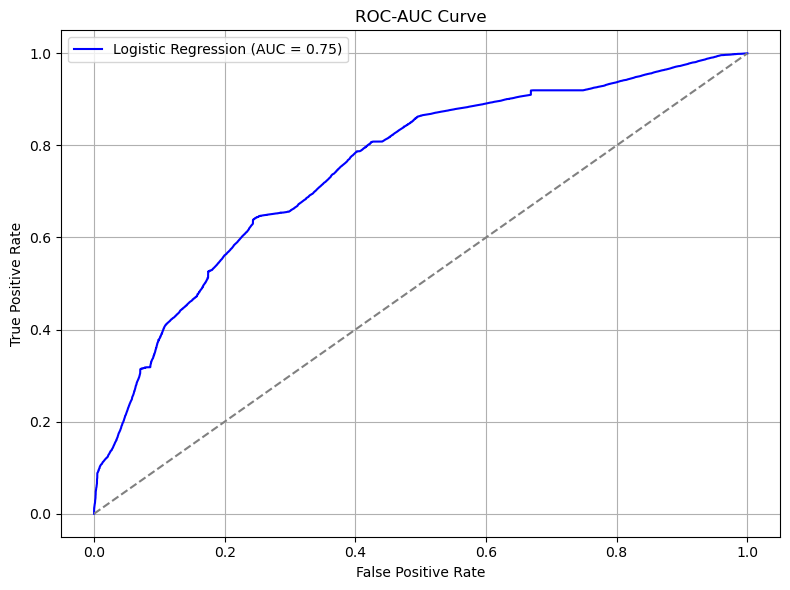

In [41]:
# Get predicted probabilities for the positive class
y_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

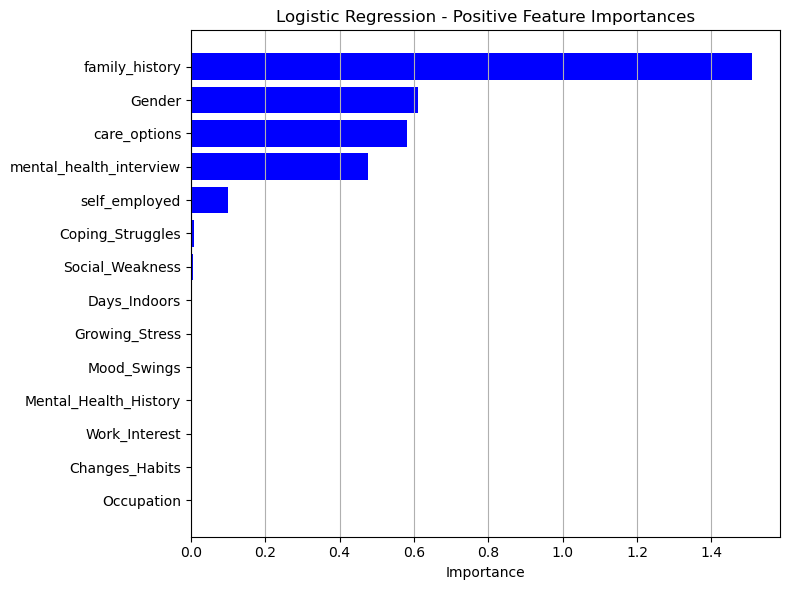

In [42]:
# Get Logistic Regression feature coefficients
log_reg_importances = np.abs(best_log_reg.coef_[0])  # Absolute values of the coefficients
feature_names = X_train.columns

# Create a DataFrame for Logistic Regression feature importance
log_reg_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': log_reg_importances
})

# Keep only positive importances
log_reg_feat_imp_df = log_reg_feat_imp_df[log_reg_feat_imp_df['Importance'] > 0]

# Sort by importance
log_reg_feat_imp_df = log_reg_feat_imp_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(log_reg_feat_imp_df['Feature'], log_reg_feat_imp_df['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Logistic Regression - Positive Feature Importances')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [13]:
# ----- Random Forest -----
rf = RandomForestClassifier(random_state=42)

# Smaller and more shallow parameter space
rf_param_dist = {
    'n_estimators': [50, 100],              # Lower number of trees
    'max_depth': [5, 10, None],             # Fewer options
    'min_samples_split': [2, 5],            # Smaller search
    'min_samples_leaf': [1, 2]              # Standard values
}

# Reduced n_iter and simpler cross-validation
rf_random_search = RandomizedSearchCV(estimator=rf,
                                      param_distributions=rf_param_dist,
                                      n_iter=10,         # Fewer combinations
                                      cv=3,
                                      scoring='accuracy',
                                      random_state=42,
                                      n_jobs=-1)

rf_random_search.fit(X_train, y_train)

# Evaluation
best_rf = rf_random_search.best_estimator_
rf_pred = best_rf.predict(X_test)

print("Random Forest - Best Hyperparameters:", rf_random_search.best_params_)
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, rf_pred))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred))

Random Forest - Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}

Confusion Matrix (Random Forest):
[[ 9757  5897]
 [ 3207 15401]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.75      0.62      0.68     15654
           1       0.72      0.83      0.77     18608

    accuracy                           0.73     34262
   macro avg       0.74      0.73      0.73     34262
weighted avg       0.74      0.73      0.73     34262



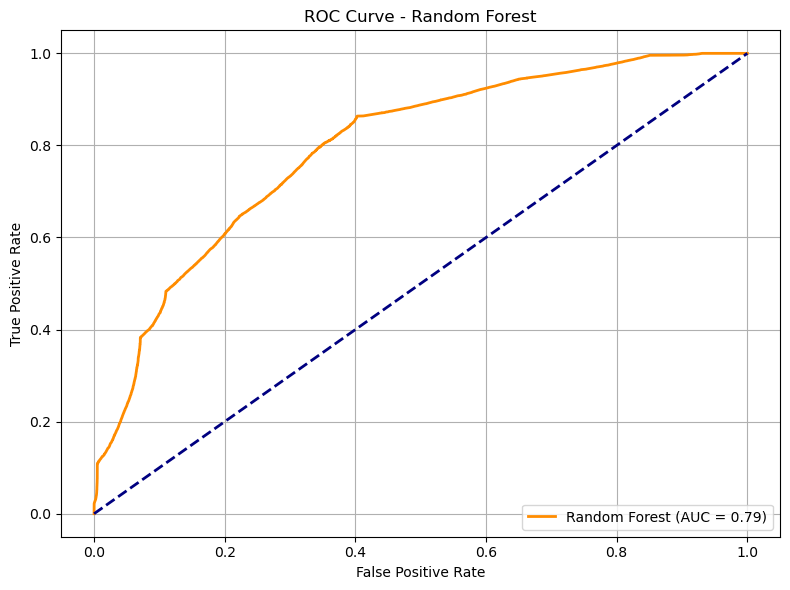

In [43]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
rf_probs = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

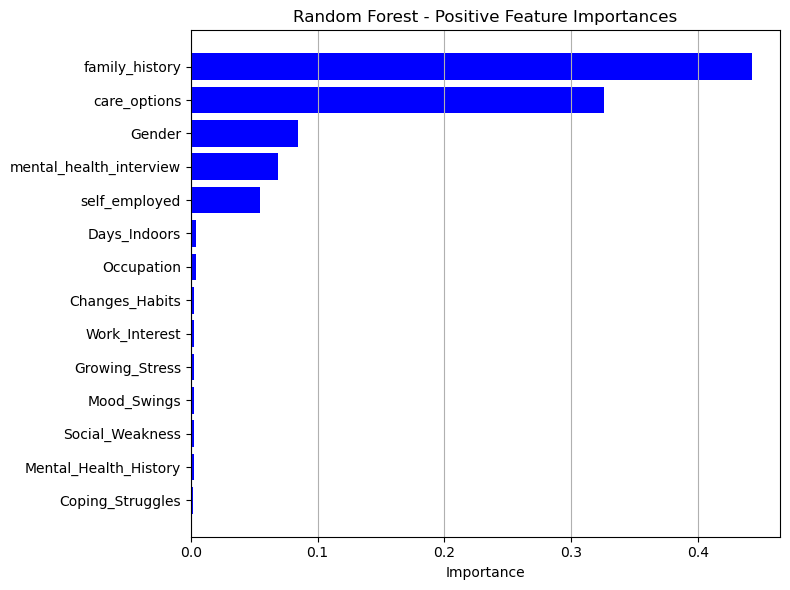

In [15]:
# Get feature importances
rf_importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
rf_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
})

# Keep only positive importances
rf_feat_imp_df = rf_feat_imp_df[rf_feat_imp_df['Importance'] > 0]

# Sort by importance
rf_feat_imp_df = rf_feat_imp_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(rf_feat_imp_df['Feature'], rf_feat_imp_df['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Random Forest - Positive Feature Importances')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [16]:
#------------ LightGBM model---------
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Simplified parameter grid
lgb_param_dist = {
    'num_leaves': [15, 31, 63],         # Smaller leaves = faster
    'max_depth': [5, 10, -1],           # Limit depth or let it grow fully (-1)
    'learning_rate': [0.05, 0.1, 0.2],  # Faster convergence
    'n_estimators': [50, 100]           # Lower trees for speed
}

# Randomized search with fewer iterations
lgb_random_search = RandomizedSearchCV(estimator=lgb_clf,
                                       param_distributions=lgb_param_dist,
                                       n_iter=10,     # Fewer combinations
                                       cv=3,
                                       scoring='accuracy',
                                       random_state=42,
                                       n_jobs=-1)

# Fit the model
lgb_random_search.fit(X_train, y_train)

# Predict and evaluate
best_lgb = lgb_random_search.best_estimator_
lgb_pred = best_lgb.predict(X_test)

print("LightGBM - Best Hyperparameters:", lgb_random_search.best_params_)
print("\nConfusion Matrix (LightGBM):")
print(confusion_matrix(y_test, lgb_pred))
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, lgb_pred))


[LightGBM] [Info] Number of positive: 74424, number of negative: 62622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 137046, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543059 -> initscore=0.172662
[LightGBM] [Info] Start training from score 0.172662
LightGBM - Best Hyperparameters: {'num_leaves': 15, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}

Confusion Matrix (LightGBM):
[[ 9371  6283]
 [ 2532 16076]]

Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     15654
           1       0.72      0.86      0.78     18608

    accuracy                           0.74     34262
   macro avg       

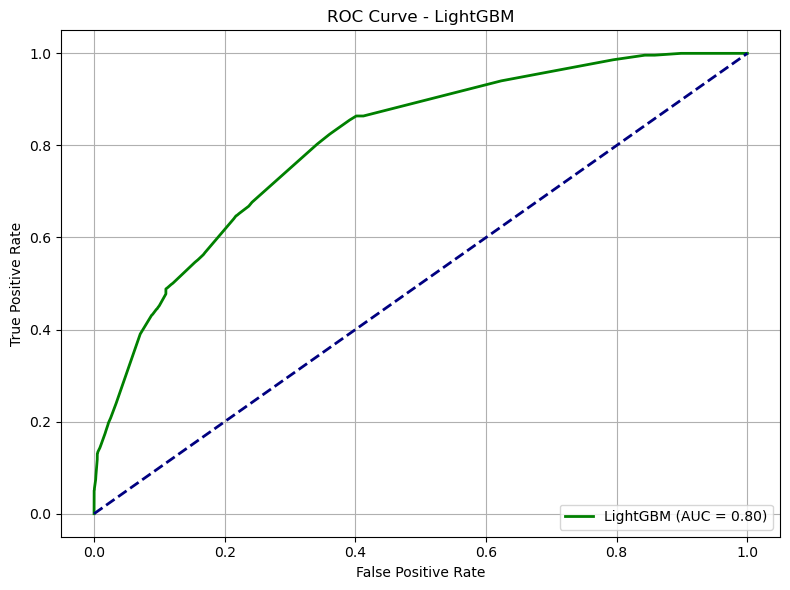

In [17]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
lgb_probs = best_lgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_probs)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, color='green', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

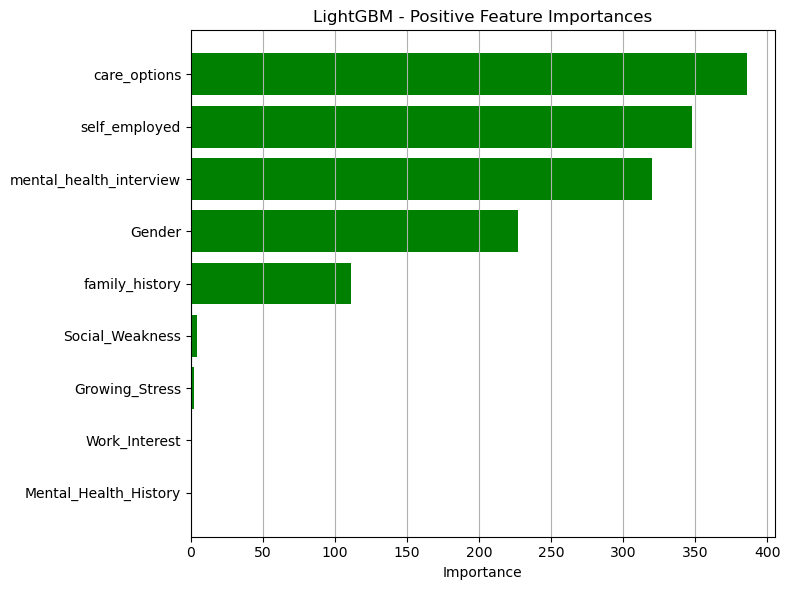

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances and corresponding feature names
importances = best_lgb.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Keep only positive importances
feat_imp_df = feat_imp_df[feat_imp_df['Importance'] > 0]

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='green')
plt.xlabel('Importance')
plt.title('LightGBM - Positive Feature Importances')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

<Figure size 1000x600 with 0 Axes>

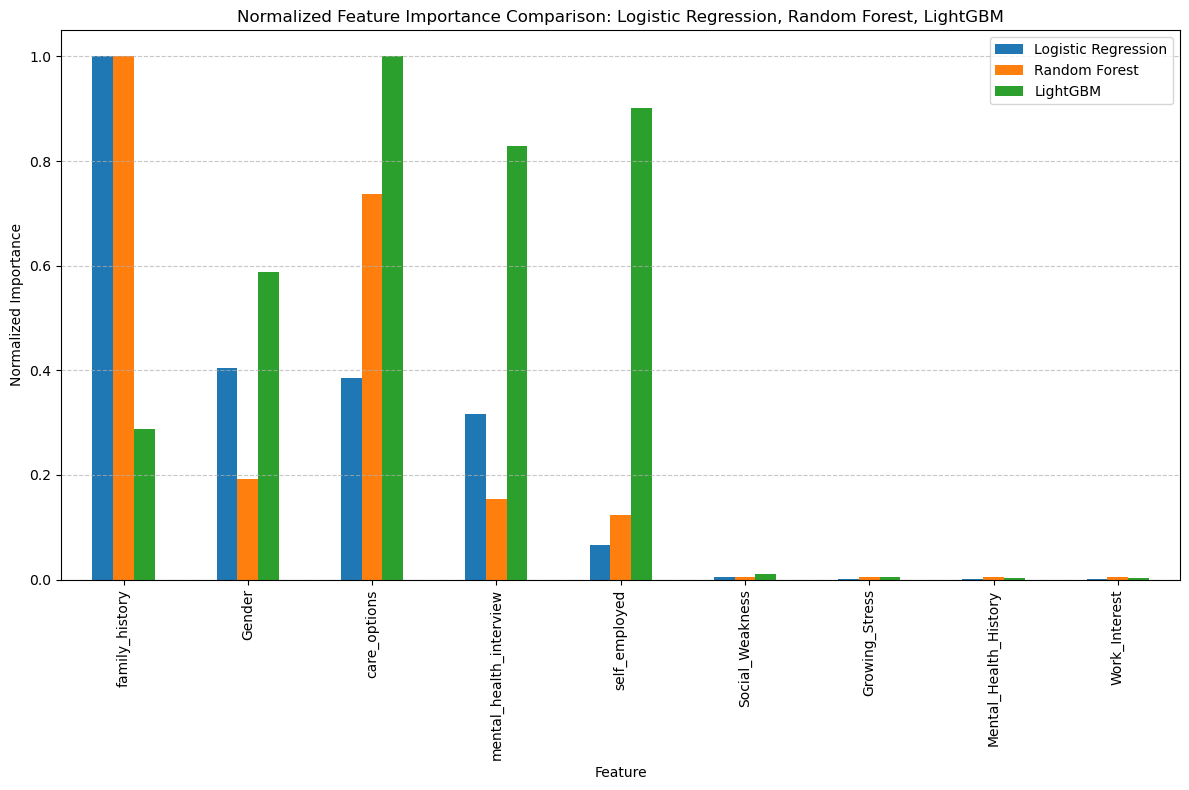

In [19]:
# 1. Logistic Regression Feature Importance (Absolute Coefficients)
log_reg_importances = np.abs(best_log_reg.coef_[0])  # Absolute values of the coefficients
log_reg_feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Logistic Regression': log_reg_importances
})
log_reg_feat_imp_df = log_reg_feat_imp_df[log_reg_feat_imp_df['Logistic Regression'] > 0]  # Only positive values
log_reg_feat_imp_df = log_reg_feat_imp_df.sort_values(by='Logistic Regression', ascending=False)  # Sorted high to low

# 2. Random Forest Feature Importance
rf_importances = best_rf.feature_importances_
rf_feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest': rf_importances
})
rf_feat_imp_df = rf_feat_imp_df[rf_feat_imp_df['Random Forest'] > 0]  # Only positive values
rf_feat_imp_df = rf_feat_imp_df.sort_values(by='Random Forest', ascending=False)  # Sorted high to low

# 3. LightGBM Feature Importance
lgb_importances = best_lgb.feature_importances_
lgb_feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LightGBM': lgb_importances
})
lgb_feat_imp_df = lgb_feat_imp_df[lgb_feat_imp_df['LightGBM'] > 0]  # Only positive values
lgb_feat_imp_df = lgb_feat_imp_df.sort_values(by='LightGBM', ascending=False)  # Sorted high to low

# Normalizing feature importances (scaling to [0, 1])
log_reg_feat_imp_df['Logistic Regression'] /= log_reg_feat_imp_df['Logistic Regression'].max()
rf_feat_imp_df['Random Forest'] /= rf_feat_imp_df['Random Forest'].max()
lgb_feat_imp_df['LightGBM'] /= lgb_feat_imp_df['LightGBM'].max()

# Merging all feature importances into a single DataFrame
merged_feat_imp_df = pd.merge(log_reg_feat_imp_df[['Feature', 'Logistic Regression']],
                               rf_feat_imp_df[['Feature', 'Random Forest']], on='Feature')
merged_feat_imp_df = pd.merge(merged_feat_imp_df, lgb_feat_imp_df[['Feature', 'LightGBM']], on='Feature')

# Plot the comparison bar chart with vertical bars, sorted high to low
plt.figure(figsize=(10, 6))
merged_feat_imp_df.set_index('Feature').plot(kind='bar', stacked=False, figsize=(12, 8))

plt.title('Normalized Feature Importance Comparison: Logistic Regression, Random Forest, LightGBM')
plt.ylabel('Normalized Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

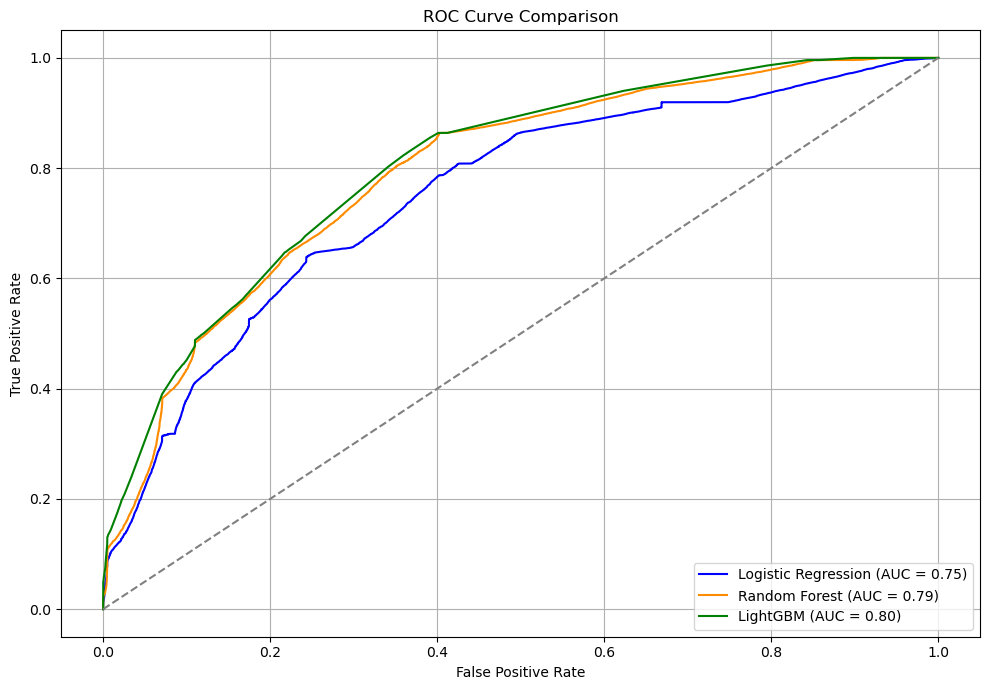

In [20]:
# Logistic Regression
y_proba_logreg = best_log_reg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_proba_logreg)

# Random Forest
rf_probs = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = auc(fpr_rf, tpr_rf)

# LightGBM
lgb_probs = best_lgb.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_probs)
auc_lgb = auc(fpr_lgb, tpr_lgb)

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})', color='green')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()